In [2]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# QUESTION 1

In [ ]:
def get_class_sample(data,labels,class_names):
    classes = np.unique(labels)
    n_classes = classes.shape[0]

    rows,cols = int(np.sqrt(n_classes)), int(np.sqrt(n_classes))
    rows  = rows + 1 if cols**2!=n_classes else rows
    fig,axes = plt.subplots(rows,cols, figsize = (6,6))
    for ax in axes.ravel():
        ax.set_axis_off()
    plt.axis('off')
    i,j = 0,0
    for ind,c in enumerate(classes):
        class_name = class_names[ind]
        idx = np.where(labels==c)[0][0]
        image = data[idx]
        axes[i,j].imshow(image,cmap = 'gray')
        axes[i,j].set_title(class_name)
        j += 1
        if(j>=cols):
            i += 1
            j = 0
    plt.show()

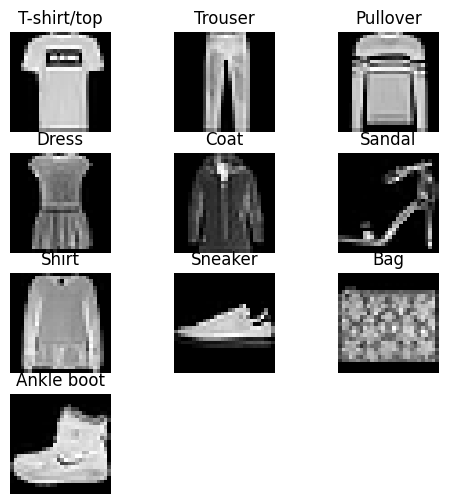

In [ ]:
get_class_sample(train_images,train_labels,class_names)

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(x):
    ex = np.exp(x)
    den = np.sum(ex)
    return ex/den

In [ ]:
class GD:
    def __init__(self,learning_rate):
        self.learning_rate = learning_rate
        
    def update(self, weights, biases, weight_gradients, bias_gradients):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate*weight_gradients[i]
            biases[i] -= self.learning_rate*bias_gradients[i]

class Fast_GD:
    def __init__(self,learning_rate,beta):
        self.learning_rate = learning_rate
        self.beta = beta
        self.uw = []
        self.ub = []
    def update(self, weights, biases, weight_gradients, bias_gradients):
        for i in range(len(weights)):
            self.uw[i] = self.beta*self.uw[i] + weight_gradients[i]  if self.uw.empty()!=True  else weight_gradients[i]
            weights[i] -= self.learning_rate*self.uw[i]
            self.ub[i] = self.beta*self.ub[i] + bias_gradients[i]    if self.ub.empty()!=True  else bias_gradients[i]
            biases[i] -= self.learning_rate*self.ub[i]
    def clear_history(self):
        self.uw = []
        self.ub = []

In [ ]:
OPTIMIZER_MAP = {
    'gd': GD,
    'mgd': Fast_GD,
    'nag': Fast_GD 
}

In [ ]:

class MyNeuralNetwork:
    def __init__(self, n_features, hidden_sizes, n_classes):
        self.n_features = n_features       #input size
        self.hidden_sizes = hidden_sizes   #number of neurons in hidden layers
        self.n_classes = n_classes         #output size
        
        self.weights = []                  #list of weights in each layer
        self.biases = []                   #list of biases in each layer

        self.g_activation = sigmoid
        self.o_activation = softmax

        self.batch_size = None
        self.optimizer_name = 'GD'
        self.optimizer = GD(learning_rate = 0.1)
    
    def network_hyperparams(self,**kwargs):
        for key, value in kwargs.items():
            if value is not None and hasattr(self,key):
                setattr(self,key,value)

    def optimizer_hyperparams(self,optimizer_name, **kwargs):
        self.optimizer_name = optimizer_name
        self.optimizer = OPTIMIZER_MAP[optimizer_name]

    def feed_forward(self,input):
        '''
        This function does a forward pass

        Arguments:
            input   : Input vector of size (n_features,1)
        
        Returns:
            out     : An output vector of probabilities of shape (n_classes,1)
            a_all   : All intermediate pre_activations
            h_all   : All intermediate activations
            
        '''
        a_all = []
        h_all = []
        h = input
        for i in len(self.biases):
            a = self.weights[i]@h+self.biases[i]
            a_all.append(a)
            h = self.g_activation(a)
            h_all.append(h)
        
        out = self.o_activation(h)
        return out,a_all,h_all

    def compute_gradient(self, true_dist, y_hat, a_all, h_all,w_lookahead = None):
        '''
        This function does feed_forward and back_propagation

        Arguments:
            input   : Input vector of size (n_features,1)
            true_dist : The true distribution of the input (one hot encoded in the correct class) of size (n_classes,1)
            y_hat     : An output vector of probabilities of shape (n_classes,1)
            a_all   : All intermediate pre_activations
            h_all   : All intermediate activations
        
        Returns:
            weight_grads : list of gradients of weights of each layer
            bias_grads   : list of gradients of biases of each layer
            
        '''
        weight_grads = []
        bias_grads = []
        prev_a_grad = -(true_dist-y_hat)
        delta = 1e-3 #derivative helper
        for i in np.arange(len(self.biases)-1,0,-1):
            weight_grads.append(prev_a_grad@(h_all[i].T))
            bias_grads.append(prev_a_grad)
            if w_lookahead is None:
                prev_h_grad = (self.weights[i].T)@prev_a_grad
            else:
                prev_h_grad = ((self.weights[i]+w_lookahead[i]).T)@prev_a_grad
            del_g = (self.g_activation(a_all[i]+delta)-self.g_activation(a_all[i]))/delta
            prev_a_grad = prev_h_grad@del_g

        return weight_grads, bias_grads

    def train(self, X, y, epochs):
        batch_start = 0
        for epoch in range(epochs):
            X_batch = X[batch_start:batch_start + self.batch_size]
            y_batch = y[batch_start:batch_start + self.batch_size]
            dw_batch = []
            db_batch = []
            loss = []
            for input,true_dist in zip(X_batch,y_batch):
                y_hat,a_all,h_all = self.feed_forward(input)
                loss.append(np.square(true_dist - y_hat))
                if self.optimizer == 'nag':
                    uw = self.optimizer.uw
                    beta = self.optimizer.beta
                    for i in range(len(uw)):
                        uw[i] = -beta*uw[i]
                    dw, db = self.compute_gradient(true_dist,y_hat,a_all,h_all, w_lookahead=uw)
                else:
                    dw, db = self.compute_gradient(true_dist,y_hat,a_all,h_all)                   
                if dw_batch.empty():
                    dw_batch = dw
                    db_batch = db
                else:
                    for i in range(len(dw_batch)):
                        dw_batch[i] += dw[i]
                        db_batch[i] += db[i]
            self.optimizer.update(self.weights, self.biases, dw_batch,db_batch)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {np.mean(loss)}")

    def predict(self, X):
        y = []
        for input in X:
            y.append(self.feed_forward(input))
        return np.stack(y)


In [ ]:
def one_hot_encoded(labels):
    n_classes = np.size(np.unique(labels))
    out = np.zeros((labels.shape[0], n_classes))
    for i,l in enumerate(labels):
        out[i,l] = 1
    return out

In [ ]:
#check reshape matches data
#train_images.reshape((train_images.shape[0],-1)).shape

(60000, 784)

In [ ]:
X,y = train_images.reshape((train_images.shape[0],-1)), one_hot_encoded(train_labels)

n_features = X.shape[1]
n_classes = 10
hidden_sizes = [10,10,n_classes]

mynn = MyNeuralNetwork(n_features, hidden_sizes, n_classes)
